# **Laboratorio: Estimación de fase del operador U**

El objetivo del ejercicio es estimar, con la suficiente precisión, la fase del operador unitario $U$ que aplica una rotación con respecto al eje $Z$ de $\frac{\pi}{9}$ al estado $|1\rangle$.

$$U|1\rangle = e^{\frac{i\pi}{9}}|1\rangle$$

**Introducción teórica**

Los operadores unitarios poseen autovalores de norma 1 por definición. El operador $U$ actúa sobre su autoestado $|\Psi\rangle$ de la siguiente forma:

$$U |\Psi\rangle = e^{i 2 \pi \theta}|\Psi\rangle = e^{i \theta'}|\Psi\rangle $$

Nótese que: 

$$\theta' = 2 \pi \theta$$

El algoritmo de estimación de fase obtiene el valor de $\theta$ dado un operador unitario y su autoestado al construir el estado correspondiente en la fase de Fourier, es decir, por la aplicación de sucesivas puertas $\textit{controlled-phase}$ que se aplican sobre los distintos qubits de estimación, se consigue el vector correspondiente a la fase a descubrir en la fase de Fourier salvo por un factor $2^{n}$, por lo que al realizar la transformada inversa de Fourier contenida en el algoritmo de estimación de fase deberá dividirse por tal factor para recuperar el valor de $\theta$ a obtener, es decir.

$$
|\Psi\rangle \longrightarrow \text{Controlled-Phase} = \sum{e^{2\pi i \theta k} |k\rangle \otimes |\Psi\rangle} =  \sum{\left(e^{2\pi i \frac{jk}{N}}\right)^{2^{n}}|j\rangle \otimes \Psi\rangle}
$$

Así, tras haber aplicado el algoritmo de estimación de fase, se obtiene $\theta$ de la siguiente manera: 

$$
|\Phi\rangle_{b} \rightarrow |\Phi\rangle_{d} \longrightarrow \theta = \frac{\Phi_{d}}{2^{n}}
$$

Siendo $|\Phi\rangle_{b}$ el estado al salir del algoritmo de estimacion de fase, el subindice b denota que su interpretación es binaria, y $|\Phi\rangle_{d}$ el estado al salir del algoritmo con interpretación decimal.


**Librerias**

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import AerSimulator

**Construcción de IFTQ**

In [13]:
# circ: circuito a donde se va a incorporar la IQFT
# nq = indica sobre qué cubits se va a aplicar, por defecto los n primeros
def iqft(circ, nq):

    for qubit in range(int(nq/2)):
        circ.swap(qubit, nq-qubit-1)
    for j in range(0,nq):
        for m in range(j):
            circ.cp(-np.pi/float(2**(j-m)), m, j)
        circ.h(j)
    return circ

**Construcción de QPE**

In [17]:
# qe = qubits de estimación, a mayor número de qubits, mayor precisión (a priori) sobre la fase estimada, como se verá a continuación puede no ser así
# phase = fase que introduce el operador unitario U

def qpe(qe,phase):
    
    qreg_estimator = QuantumRegister(qe,'q')
    qreg_state = QuantumRegister(1,'state')
    creg= ClassicalRegister(qe,'b')
    circ = QuantumCircuit(qreg_estimator,qreg_state,creg)
    
    circ.initialize([0,1],qreg_state[0])
    
    for i in range(qe):
          circ.h(qreg_estimator[i])
    
    for i in range(qe):
          circ.cp(phase * 2 ** i,qreg_estimator[i],qreg_state[0])
    
    iqft(circ,qe)
    
    circ.measure(qreg_estimator,creg)
    
    shots=20000
    backend = AerSimulator(method='statevector')
    job = backend.run(transpile(circ),shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    max_state = max(counts, key=counts.get)
    
    theta = int(max_state, 2) / 2 ** qe
    
    return theta

**Cálculo de $\theta$**

In [19]:
qubits = []
phases = []


for i in range(1,15):
    
    phase = np.pi/9
    qe = i
  
    qubits.append(qe)
    phases.append(qpe(qe,phase))

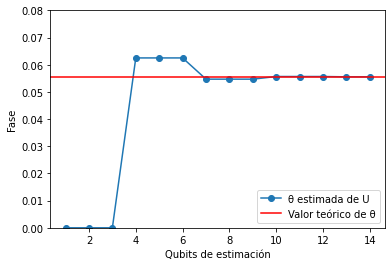

In [23]:
plt.plot(qubits,phases,'-o')
plt.axhline(y=1/18, color='red')
plt.legend(['\u03B8 estimada de U','Valor teórico de \u03B8'],loc='lower right')
plt.xlabel('Qubits de estimación')
plt.ylabel('Fase')
plt.ylim(0, 0.08)
plt.show()

Como s epuede observar, se puede decir que la fase estimada converge para 10 qubits de forma aproximada al valor teórico, así:

In [26]:
phase = np.pi/9
qubits_estimacion = 10
print('\u03B8 estimada para 10 qubits es:',qpe(qubits_estimacion,phase))

θ estimada para 10 qubits es: 0.0556640625
